# Non-Linear Forecasting Examples

Check out nickc1.github.io/nla for a more complete introduction.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
import seaborn as sns
sns.set_style('ticks')
sns.set_context(context='paper',font_scale=1.3)
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#alter the line below to correspond to your file system
nonlinpy_dir = '/Users/nickc/Documents/skNLA'
sys.path.append(nonlinpy_dir)

In [4]:
import skNLA as nla
import skNLA.data_gen as data

# Regression Basic Example

#### Generate some data

In [5]:
np.random.seed(6)
X = np.random.randint(0, 5, size=(6,3))
y = np.random.randint(0, 5, size=(6,2))
print('X=\n', X)
print('y=\n', y)

X=
 [[2 1 3]
 [4 2 2]
 [0 1 1]
 [3 1 2]
 [1 4 4]
 [1 0 2]]
y=
 [[4 4]
 [3 2]
 [2 1]
 [2 3]
 [1 4]
 [0 2]]


#### Initiate NLA class
Going to choose uniform weights

In [6]:
weights = 'uniform' #use a uniform weighting for the near neighbors
NLA = nla.Regression(weights) # initiate the nonlinear forecasting class

#### Split into training and test data

In [7]:
Xtrain = X[:4]
Xtest = X[4:]
ytrain = y[:4]
ytest = y[4:]

#### Fit the training data

In [8]:
NLA.fit(Xtrain, ytrain)

#### Make the prediction for different numbers of near neighbors

In [9]:
nn_list = [1,3]
preds = NLA.predict(Xtest,nn_list)
print(len(preds))

2


In [10]:
for nn,p in zip(nn_list,preds):
    print(nn,'near neighbor:')
    print(p)

1 near neighbor:
[[ 4.  4.]
 [ 4.  4.]]
3 near neighbor:
[[ 3.          3.        ]
 [ 2.66666667  2.66666667]]


#### Quick look at the indices

In [11]:
NLA.ind

array([[0, 1, 3, 2],
       [0, 2, 3, 1]])

#### Quick look at the distances
Distances use the [Minkowski Metric](https://www.wikiwand.com/en/Minkowski_distance)

In [12]:
np.around(NLA.dist,2)

array([[ 3.32,  4.12,  4.12,  4.36],
       [ 1.73,  1.73,  2.24,  3.61]])

#### Calculation for first distance value

In [13]:
diff = np.square(X[0]-X[4]).sum()
np.sqrt(diff)

3.3166247903553998

In [14]:
NLA.dist

array([[ 3.31662479,  4.12310563,  4.12310563,  4.35889894],
       [ 1.73205081,  1.73205081,  2.23606798,  3.60555128]])

In [15]:
test = [4.12310563,2.23606798]
print( np.mean(test) )
print( np.std(test) )

3.179586805
0.943518825


In [16]:
mean,std = NLA.dist_stats(nn_list)
print(mean)
print(std)

[ 2.5243378  3.1795868]
[ 0.79228699  0.94351882]


#### Calculate the score

In [17]:
NLA.score(ytest)

array([[-49.        ,  -1.        ],
       [-21.22222222,   0.27777778]])

#### Predict for individual neighbors

In [18]:
preds = NLA.predict_individual(Xtest, nn_list)
print(len(preds))

2


In [19]:
for nn,p in zip(nn_list,preds):
    print(nn,'near neighbor:')
    print(p)

1 near neighbor:
[[4 4]
 [4 4]]
3 near neighbor:
[[2 3]
 [2 3]]


#### Score the values

In [20]:
NLA.score(ytest)

array([[-49.,  -1.],
       [ -9.,   0.]])

The scores are terrible as it is just random data!

# Classification Example

In [21]:
np.random.seed(3)
X = np.random.randint(0, 5, size=(6,3))
y = np.random.randint(0, 5, size=(6,2))
print('X=\n', X)
print('y=\n', y)

X=
 [[2 0 1]
 [3 0 0]
 [0 3 2]
 [3 1 1]
 [2 0 4]
 [4 0 2]]
y=
 [[1 2]
 [2 2]
 [4 1]
 [3 2]
 [0 1]
 [2 0]]


In [22]:
weights = 'uniform' #use a uniform weighting for the near neighbors
NLA = nla.Classification(weights) # initiate the nonlinear forecasting class

#### Split into training and testing

In [23]:
Xtrain = X[:4]
Xtest = X[4:]
ytrain = y[:4]
ytest = y[4:]

In [24]:
NLA.fit(Xtrain, ytrain)

In [25]:
nn_list = [1,3]
preds = NLA.predict(Xtest, nn_list)
print(len(preds))

2


Look at the predictions

In [26]:
for nn,p in zip(nn_list,preds):
    print(nn,'near neighbor:')
    print(p)

1 near neighbor:
[[ 1.  2.]
 [ 1.  2.]]
3 near neighbor:
[[ 1.  2.]
 [ 1.  2.]]


In [27]:
NLA.ind

array([[0, 1, 2, 3],
       [0, 1, 2, 3]])

In [28]:
np.around(NLA.dist,2)

array([[ 0.33,  0.67,  1.  ,  1.  ],
       [ 0.67,  0.67,  0.67,  1.  ]])

In [29]:
diff = 1 - np.mean(X[0]==X[4])
diff

0.33333333333333337

In [30]:
NLA.score(ytest)

array([[-1., -1.],
       [-1., -1.]])

In [31]:
preds = NLA.predict_individual(Xtest,nn_list)
print(len(preds))

2


In [32]:
for nn,p in zip(nn_list,preds):
    print(nn,'near neighbor:')
    print(p)

1 near neighbor:
[[1 2]
 [1 2]]
3 near neighbor:
[[4 1]
 [4 1]]


# One Dimensional
First we are going to check out a one dimensional example. Here is what we are going to do:

1. Generate the time series
2. Calculate the mutual information of the time series
3. Embed the time series (not going to explore embedding dimension)
4. Train on the first 75% of the time series
5. Predict the last 25% over a range of near neighbors and forecast distances

### 1. Generate the time series

In [5]:
X = data.lorenz()[:,0] #only going to use the x values from the lorenz system

In [6]:
X.shape

(10000,)

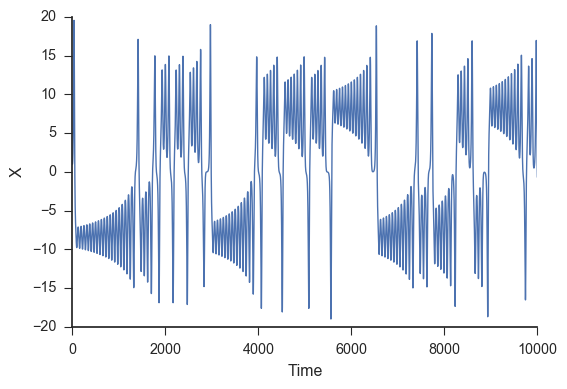

In [7]:
fig,ax = plt.subplots()
ax.plot(X,linewidth=1)
ax.set_xlabel('Time')
ax.set_ylabel('X')
sns.despine()

In [8]:
#fig.savefig('../figures/lorenz.png',bbox_inches='tight')

### 2. Calculate the mutual information of the time series

In [9]:
E = nla.Embed(X) #initiate the embed class

In [10]:
max_lag = 50
mi = E.mutual_information(max_lag)

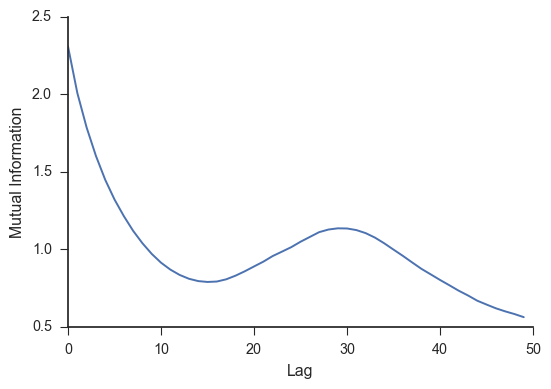

In [11]:
fig,ax=plt.subplots()
ax.plot(mi)
#ax.plot(mi2)
ax.set_xlabel('Lag')
ax.set_ylabel('Mutual Information')
sns.despine()

In [12]:
#fig.savefig('../figures/lorenz_mutual_info.png',bbox_inches='tight')

### 3. Embed the time series
First minimum of the mutual information is at 18, so we will take that as our lag.

In [13]:
lag = 18
embed = 3
predict = 36 #predicting out to double to lag
X,y = E.embed_vectors_1d(lag,embed,predict)

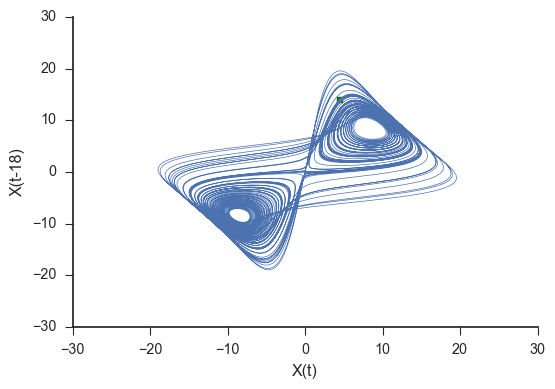

In [25]:
fig,ax = plt.subplots()
ax.plot(X[:,0],X[:,1],linewidth=.5)
ax.scatter(X[1750,0],X[1750,1],c='g',marker='s')
ax.set_xlabel('X(t)')
ax.set_ylabel('X(t-18)')
sns.despine()

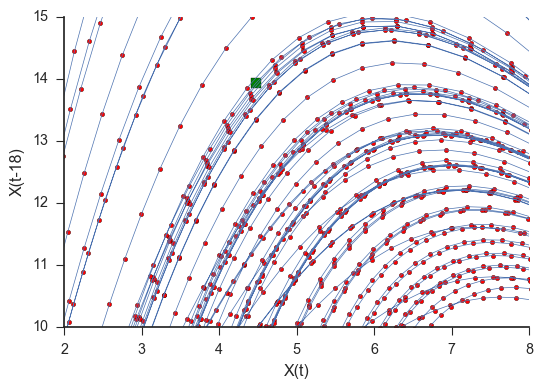

In [34]:
fig,ax = plt.subplots()
ax.plot(X[:,0],X[:,1],linewidth=.5)
ax.scatter(X[:,0],X[:,1],c='r',s=10)
ax.scatter(X[1750,0],X[1750,1],c='g',s=60,marker='s')
ax.set_xlabel('X(t)')
ax.set_ylabel('X(t-18)')
ax.set_xlim(2,8)
ax.set_ylim(10,15)
sns.despine()

In [48]:
r1 = .15*np.random.randn(len(X)) + X[:,0]
r2 = .15*np.random.randn(len(X)) + X[:,1]

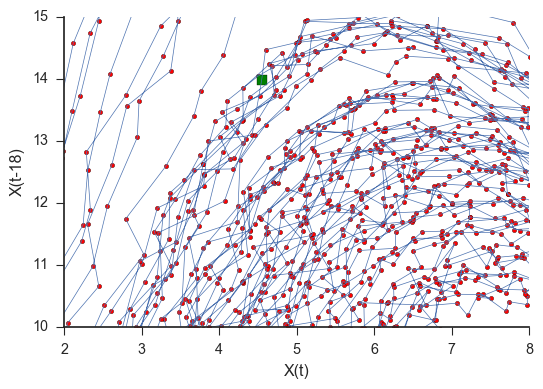

In [49]:
fig,ax = plt.subplots()
ax.plot(r1,r2,linewidth=.5)
ax.scatter(r1,r2,c='r',s=10)
ax.scatter(r1[1750],r2[1750],c='g',s=60,marker='s')
ax.set_xlabel('X(t)')
ax.set_ylabel('X(t-18)')
ax.set_xlim(2,8)
ax.set_ylim(10,15)
sns.despine()

In [50]:
#fig.savefig('../figures/zoom_embedded_lorenz_noise.png',bbox_inches='tight')

In [35]:
#fig.savefig('../figures/zoom_embedded_lorenz.png',bbox_inches='tight')

In [43]:
#fig.savefig('../figures/embedded_lorenz.png',bbox_inches='tight')

### 4. Train on the first 75% of the time series

In [51]:
#split it into training and testing sets
train_len = int(.75*len(X))
Xtrain = X[0:train_len]
ytrain = y[0:train_len]
Xtest = X[train_len:]
ytest = y[train_len:]

In [52]:
weights = 'distance' #use a distance weighting for the near neighbors
NLA = nla.Regression(weights) # initiate the nonlinear forecasting class

In [53]:
NLA.fit(Xtrain,ytrain) #fit the training data

### 5. Predict the last 25% of the time series

In [54]:
#NLF.dist_calc(Xtest) #calculate the distance all the near neighbors

In [55]:
nn_list = [10,100,300]
ypred = NLA.predict(Xtest,nn_list) #predictions using the 10 nearest neighbors

In [56]:
score = NLA.score(ytest) #score the predictions against the actual values

In [57]:
print(score.shape)
print(len(ypred))

(3, 36)
3


Plot up the prediction that is 36 time steps ahead and compare that to the actual evolution of the time series

In [58]:
ypred[0].shape

(2482, 36)

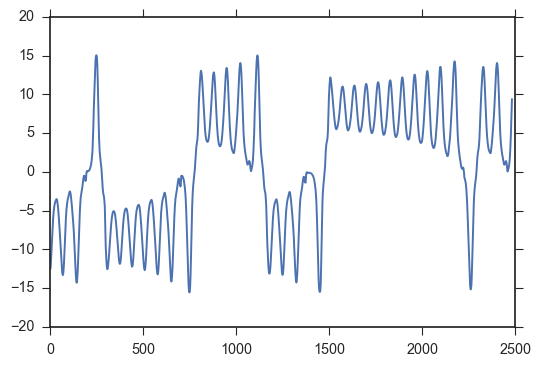

In [59]:
plt.plot(ypred[2][:,0])

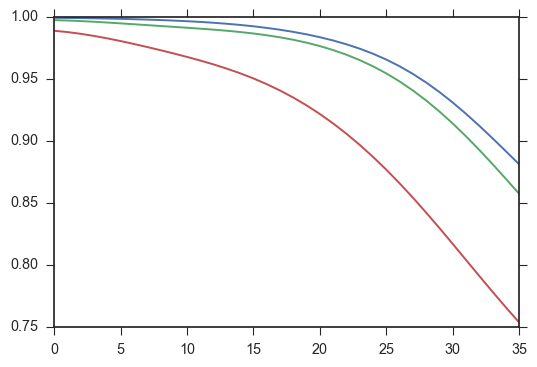

In [60]:
plt.plot(score.T);

In [77]:
nn_list = np.arange(1,7000,10)
ypred = NLA.predict_individual(Xtest,nn_list)
d_mean, d_std = NLA.dist_stats(nn_list)

In [78]:
score = NLA.score(ytest, how='corrcoef')

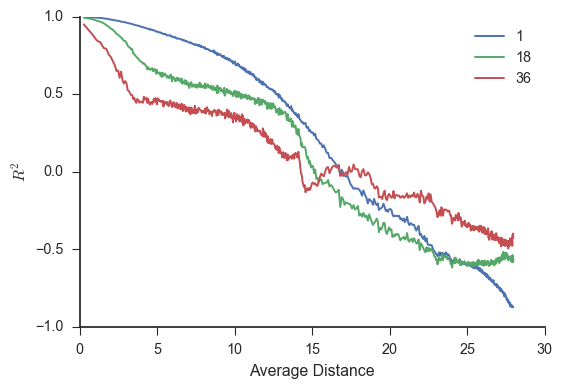

In [119]:
fig,ax = plt.subplots()
ax.plot(d_mean,score[:,0], label='1')
ax.plot(d_mean,score[:,17], label='18')
ax.plot(d_mean,score[:,35], label='36')
ax.legend()
sns.despine()
ax.set_ylabel('$R^2$')
ax.set_xlabel('Average Distance')

In [120]:
#fig.savefig('../figures/predict_individual_lorenz.png',bbox_inches='tight')

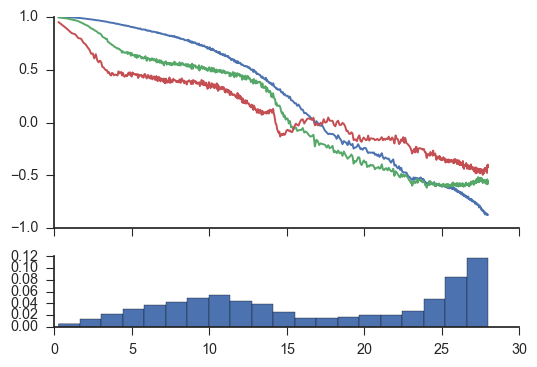

In [116]:
fig,ax = plt.subplots(2, sharex=True,gridspec_kw = {'height_ratios':[3,1]})
ax[0].plot(d_mean,score[:,0], label='1')
ax[0].plot(d_mean,score[:,17], label='18')
ax[0].plot(d_mean,score[:,35], label='36')
ax[1].hist(d_mean,20,normed=True)
sns.despine()

(array([ 0.00927938,  0.02629156,  0.03969511,  0.05103657,  0.04072615,
         0.01958979,  0.01649667,  0.01958979,  0.0371175 ,  0.10104209]),
 array([  0.2562613 ,   3.02738369,   5.79850607,   8.56962846,
         11.34075084,  14.11187323,  16.88299561,  19.654118  ,
         22.42524038,  25.19636277,  27.96748515]),
 <a list of 10 Patch objects>)

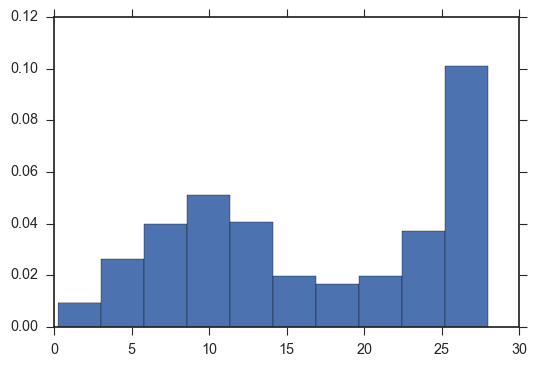

In [102]:
plt.hist(d_mean,normed=True)

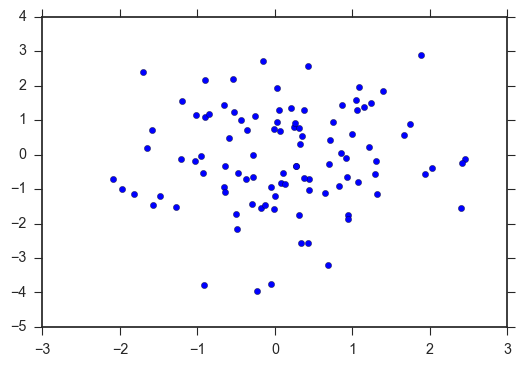

In [89]:
plt.scatter(x,y)

In [ ]:
d_mean,score[:,0]

AttributeError: Unknown property vertical

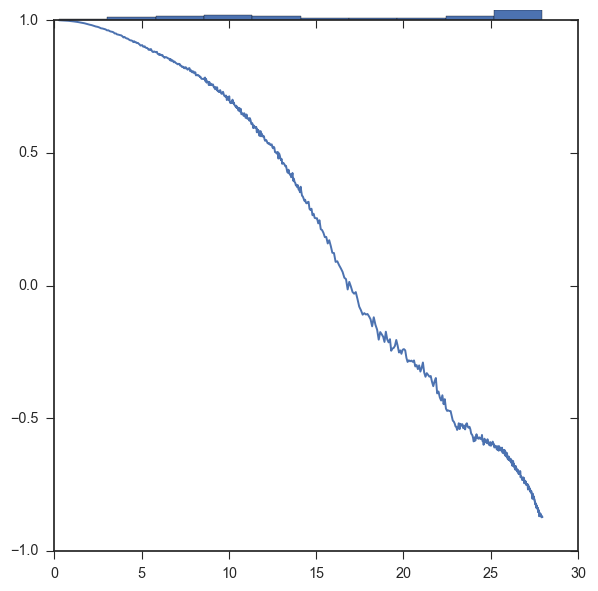

In [99]:
# Use JointGrid directly to draw a custom plot
grid = sns.JointGrid(d_mean,score[:,0], space=0, size=6, ratio=50)
grid.plot_joint(plt.plot)
grid.plot_marginals(plt.hist)

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


AttributeError: Unknown property height

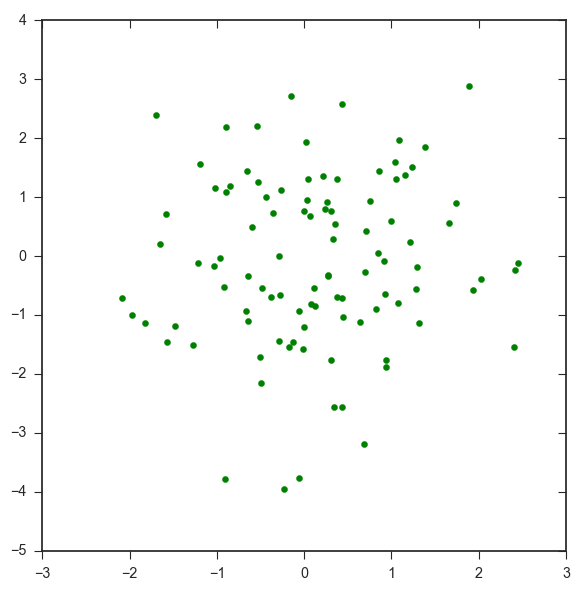

In [91]:
rs = np.random.RandomState(9)
mean = [0, 0]
cov = [(1, 0), (0, 2)]
x, y = rs.multivariate_normal(mean, cov, 100).T

# Use JointGrid directly to draw a custom plot
grid = sns.JointGrid(x, y, space=0, size=6, ratio=50)
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")

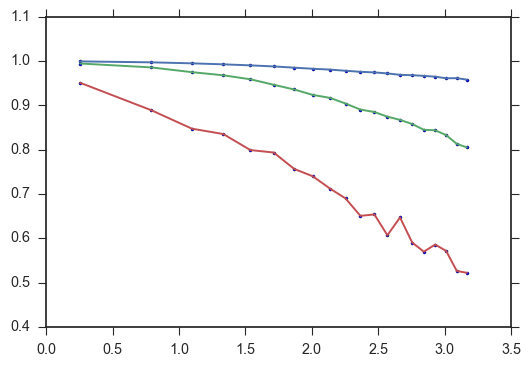

In [84]:
plt.plot(d_mean[0:20],score[0:20,0])
plt.scatter(d_mean[0:20],score[0:20,0],s=5)

plt.plot(d_mean[0:20],score[0:20,17])
plt.scatter(d_mean[0:20],score[0:20,17],s=5)

plt.plot(d_mean[0:20],score[0:20,35])
plt.scatter(d_mean[0:20],score[0:20,35],s=5)

(array([  4.,  10.,  18.,  24.,  30.,  34.,  38.,  44.,  46.,  37.,  34.,
         24.,  14.,  13.,  14.,  17.,  17.,  17.,  24.,  41.]),
 array([  0.2562613 ,   1.49789257,   2.73952384,   3.9811551 ,
          5.22278637,   6.46441764,   7.70604891,   8.94768017,
         10.18931144,  11.43094271,  12.67257397,  13.91420524,
         15.15583651,  16.39746778,  17.63909904,  18.88073031,
         20.12236158,  21.36399284,  22.60562411,  23.84725538,  25.08888664]),
 <a list of 20 Patch objects>)

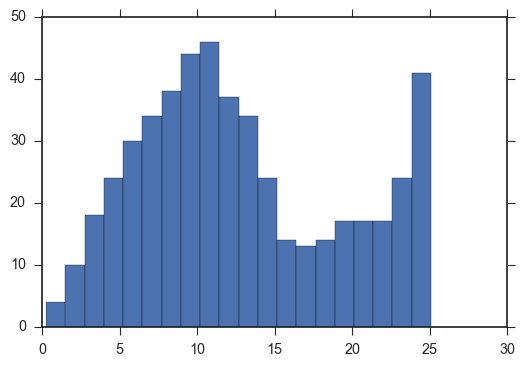

In [69]:
plt.hist(d_mean,20)

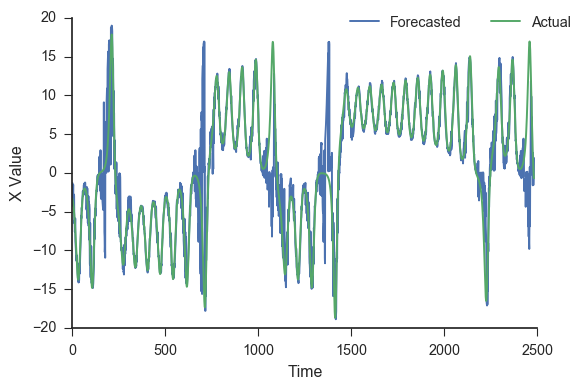

In [59]:
fig,ax = plt.subplots()

ax.plot(ypred[1][:,35],label='Forecasted');
ax.plot(ytest[:,35],label='Actual');
ax.set_xlabel('Time')
ax.set_ylabel('X Value')
ax.legend(bbox_to_anchor=(1.1, 1.05),ncol=2)
sns.despine()

In [60]:
#fig.savefig('../figures/lorenz_forecast.png',bbox_inches='tight')

### 5a. Predict over a range of near neigbors
Takes roughly 30 seconds to run on a macbook air

# Two Dimensional Continuous
Here we are going to use the exact same procedure as we did for the one dimensional case.

1. Generate the 2D series
2. Calculate the mutual information of the 2D series
3. Embed the 2D series (not going to explore embedding dimension)
4. Train on the first 75% of the 2D series
5. Predict the last 25% over a range of near neighbors and forecast distances


### 1. Generate the 2D series

In [61]:
X = data.chaos2D(sz=256)

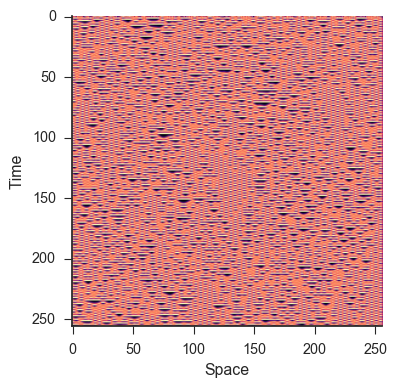

In [62]:
fig,ax = plt.subplots()
ax.imshow(X,cmap='magma')
ax.set_xlabel('Space')
ax.set_ylabel('Time')
sns.despine()

In [63]:
#fig.savefig('../figures/2d_chaos.png',bbox_inches='tight')

### 2. Calculate the mutual information of the series

In [64]:
E2 = nla.Embed(X)

In [65]:
rmi,cmi,rmut,cmut = E2.mutual_information_spatial(30)

In [66]:
print(rmi.shape)
print(cmi.shape)
print(rmut.shape)
print(cmut.shape)

(30,)
(30,)
(128, 30)
(128, 30)


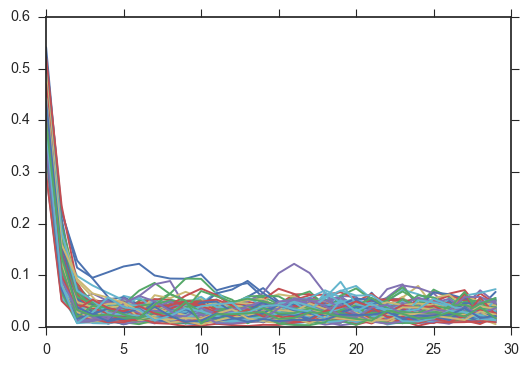

In [67]:
plt.plot(cmut.T);

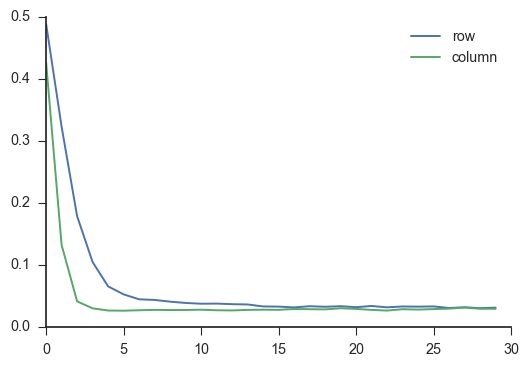

In [68]:
plt.plot(rmi,label='row')
plt.plot(cmi,label='column')
plt.legend()
sns.despine()

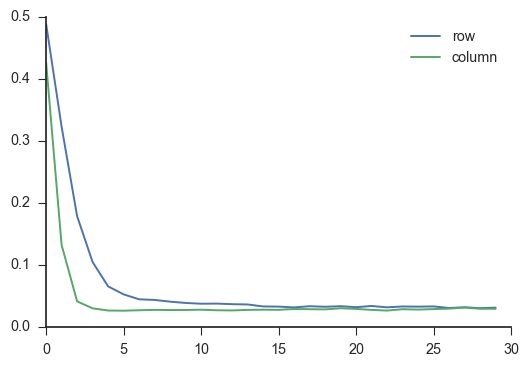

In [69]:
plt.plot(rmi,label='row')
plt.plot(cmi,label='column')
plt.legend()
sns.despine()

### 3. Embed the 2D series

Looks like the row has a mutual information minimum around 6 and the column has a minimum around 5.

In [70]:
lag = (4,2)
embed= (2,3)
predict = 7

X,y = E2.embed_vectors_2d(lag,embed,predict)

targets before loop: (6254, 7)


### 4. Train on the first 75% of data

In [71]:
#split it into training and testing sets
train_len = int(.75*len(X))
Xtrain = X[0:train_len]
ytrain = y[0:train_len]
Xtest = X[train_len:]
ytest = y[train_len:]

In [72]:
weights = 'distance' #use a distance weighting for the near neighbors
NLA = nla.Regression(weights) # initiate the nonlinear forecasting class

In [73]:
NLA.fit(Xtrain,ytrain) #fit the training data

### 5. Predict the last 25% of the data

In [74]:
nn_list = [10]
ypred = NLA.predict(Xtest,nn_list) #predictions using the 10 nearest neighbors
score = NLA.score(ytest) #score the predictions against the actual values

In [75]:
print(score.shape)
print(len(ypred))

(1, 7)
1


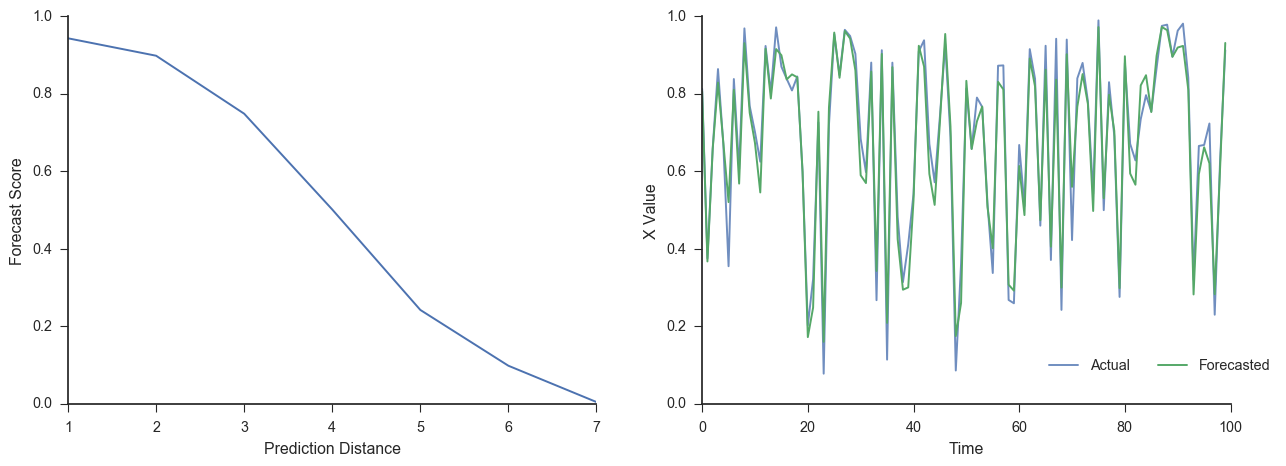

In [76]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(1,8),score.ravel())
ax[0].set_xlabel('Prediction Distance')
ax[0].set_ylabel('Forecast Score')

ax[1].plot(ytest[0:100,0],label='Actual',alpha=.8);
ax[1].plot(ypred[0][0:100,0],label='Forecasted');
ax[1].set_xlabel('Time')
ax[1].set_ylabel('X Value')
ax[1].legend(bbox_to_anchor=(1.1, .15),ncol=2)
sns.despine()

In [77]:
#fig.savefig('../figures/2d_chaos_forecast.png',bbox_inches='tight')

### 5a. Predict over a range of near neighbors

In [78]:
nn_list = np.arange(1,200,10,dtype='int')
preds = NLA.predict(Xtest,nn_list)

In [79]:
s_range = NLA.score(ytest)

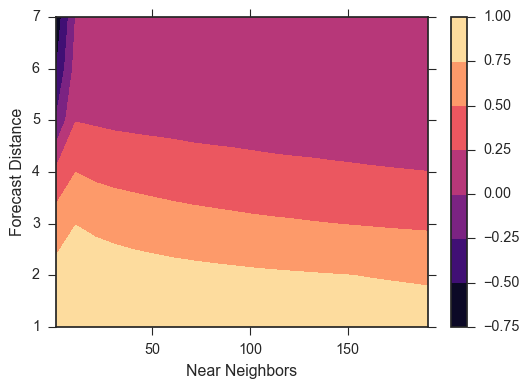

In [80]:
fig,ax = plt.subplots()
cax = ax.contourf(nn_list,np.arange(1,8),s_range.T,cmap='magma');
ax.set_xlabel('Near Neighbors')
ax.set_ylabel('Forecast Distance')
fig.colorbar(cax);

## Predict Individaul

In [81]:
preds = NLA.predict_individual(Xtest,nn_list)
s_range = NLA.score(ytest)

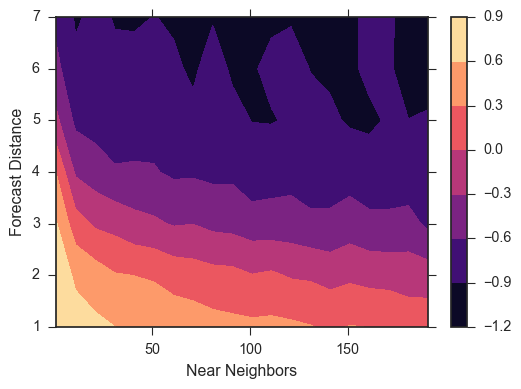

In [82]:
fig,ax = plt.subplots()
cax = ax.contourf(nn_list,np.arange(1,8),s_range.T,cmap='magma');
ax.set_xlabel('Near Neighbors')
ax.set_ylabel('Forecast Distance')
fig.colorbar(cax);

# Two Dimensional - Discrete
Again we are going to use the exact same procedure.

1. Generate the 2D discrete image
2. Calculate the mutual information of the 2D image
3. Embed the 2D image (not going to explore embedding dimension)
4. Train on the first 75% of the 2D image
5. Predict the last 25% over a range of near neighbors and forecast distances

### 1. Generate the 2D discrete image

In [83]:
X = data.voronoiMatrix(percent=.01)

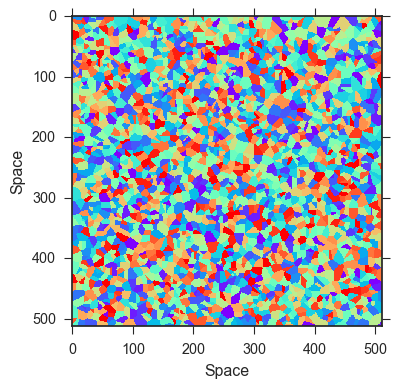

In [84]:
fig,ax = plt.subplots()
ax.imshow(X,interpolation='none',cmap='rainbow')
ax.set_ylabel('Space')
ax.set_xlabel('Space')

In [85]:
#fig.savefig('../figures/2d_voronoi.png',bbox_inches='tight')

### 2. Calculate the mutual information

In [86]:
E = nla.Embed(X)

In [87]:
mi = E.mutual_information_spatial(50,digitize=False)

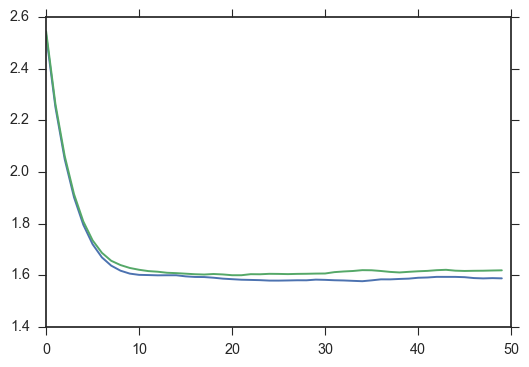

In [88]:
plt.plot(mi[0]);
plt.plot(mi[1]);

### 3. Embed the 2D image

In [89]:
lag = (8,8)
emb = (2,2)
predict = 8
X,y = E.embed_vectors_2d(lag,emb,predict,percent=.02)

targets before loop: (5011, 8)


### 4. Train on 75% of the image

In [90]:
#split it into training and testing sets
train_len = int(.75*len(X))
Xtrain = X[0:train_len]
ytrain = y[0:train_len]
Xtest = X[train_len:]
ytest = y[train_len:]

In [91]:
weights = 'distance' #use a distance weighting for the near neighbors
NLA = nla.Classification(weights) # initiate the nonlinear forecasting class

In [92]:
NLA.fit(Xtrain,ytrain) #fit the training data

### Predict the last 25% of the image

In [93]:
nn_list = [5]
ypred = NLA.predict(Xtest,nn_list) #predictions using the 10 nearest neighbors
score = NLA.score(ytest) #score the predictions against the actual values

In [94]:
print(score.shape)
print(len(ypred))

(1, 8)
1


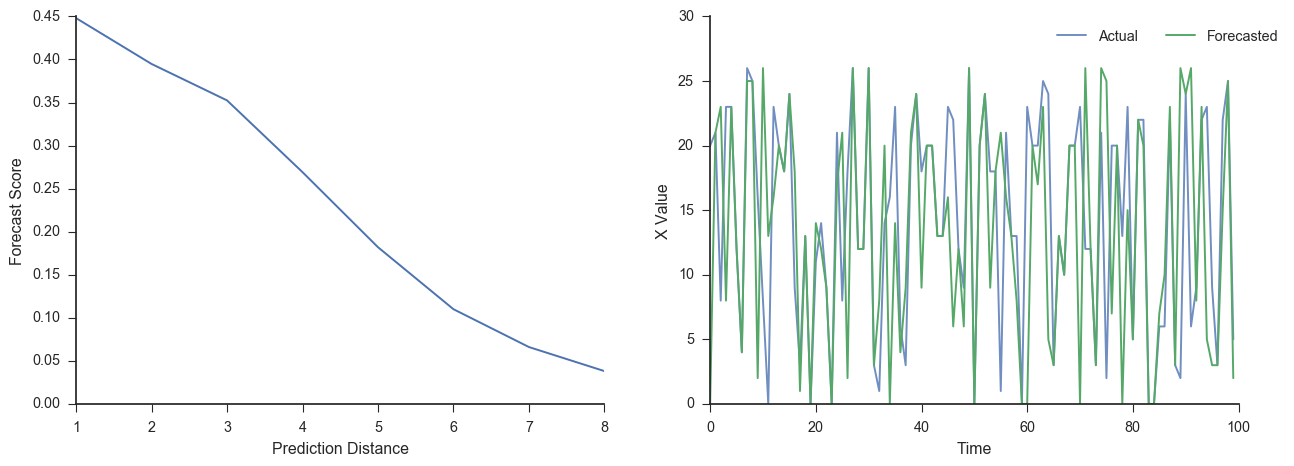

In [95]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(1,9),score.ravel())
ax[0].set_xlabel('Prediction Distance')
ax[0].set_ylabel('Forecast Score')

ax[1].plot(ytest[0:100,0],label='Actual',alpha=.8);
ax[1].plot(ypred[0][0:100,0],label='Forecasted');
ax[1].set_xlabel('Time')
ax[1].set_ylabel('X Value')
ax[1].legend(bbox_to_anchor=(1.1, 1.),ncol=2)
sns.despine()

In [96]:
#fig.savefig('../figures/2d_voronoi_forecast.png',bbox_inches='tight')

### 5a. Predict over a range of Near Neighbors

In [97]:
len(Xtest)

1253

In [98]:
nn_list = np.arange(1,len(Xtest),100,dtype='int')
preds = NLA.predict(Xtest,nn_list)

In [99]:
s_range = NLA.score(ytest)

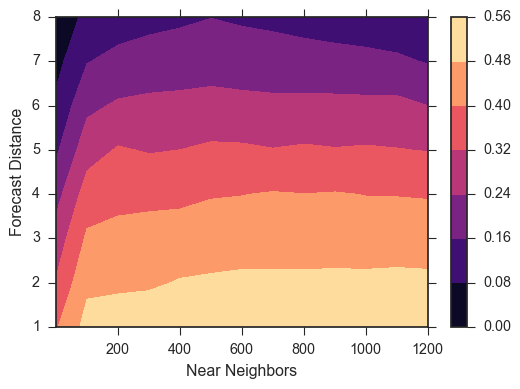

In [100]:
fig,ax = plt.subplots()
cax = ax.contourf(nn_list,np.arange(1,9),s_range.T,cmap='magma');
ax.set_xlabel('Near Neighbors')
ax.set_ylabel('Forecast Distance')
fig.colorbar(cax);

## Predict Individual

In [101]:
preds = NLA.predict_individual(Xtest,nn_list)
s_range = NLA.score(ytest)

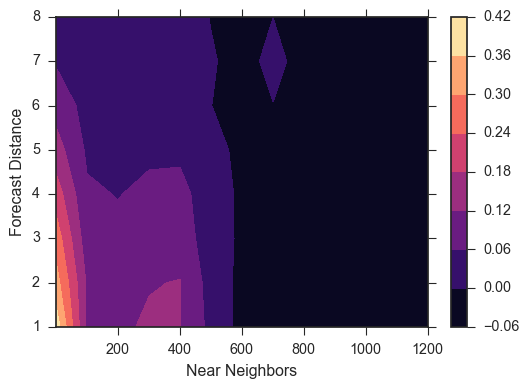

In [102]:
fig,ax = plt.subplots()
cax = ax.contourf(nn_list,np.arange(1,9),s_range.T,cmap='magma');
ax.set_xlabel('Near Neighbors')
ax.set_ylabel('Forecast Distance')
fig.colorbar(cax);

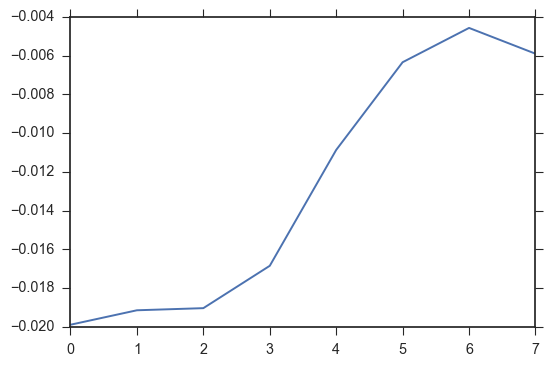

In [103]:
plt.plot(s_range[-1,:]);

# Different Levels of Noise

In [104]:
noise_levels = np.linspace(0,.2,6)
D = []
for noise in noise_levels:
    
    D.append(data.logistic_map(sz=512) + np.random.randn(512)*noise) 

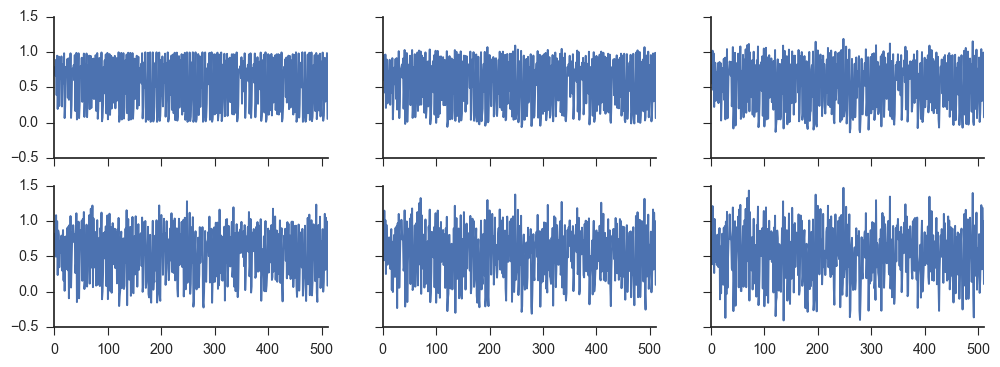

In [105]:
fig,axes = plt.subplots(2,3,figsize=(12,4),sharex=True,sharey=True)

for ax,ts in zip(axes.ravel(),D):
    
    ax.plot(ts)
    ax.set_xlim(0,512)
sns.despine()

In [106]:
E = nla.Embed(D[0]) #initiate the embed class
max_lag = 10
mi = E.mutual_information(max_lag)

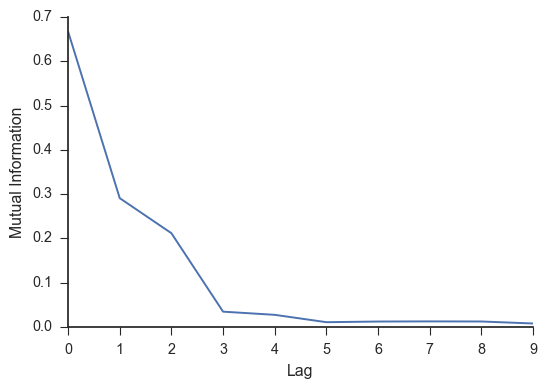

In [107]:
fig,ax=plt.subplots()
ax.plot(mi)
#ax.plot(mi2)
ax.set_xlabel('Lag')
ax.set_ylabel('Mutual Information')
sns.despine()

In [108]:
lag = 2
embed = 2
predict = 4 #predicting out to double to lag
X,y = E.embed_vectors_1d(lag,embed,predict)

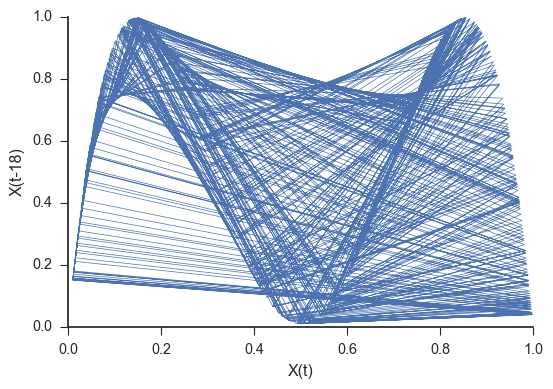

In [109]:
fig,ax = plt.subplots()
ax.plot(X[:,0],X[:,1],linewidth=.5)
ax.set_xlabel('X(t)')
ax.set_ylabel('X(t-18)')
sns.despine()

In [126]:
nn_list = np.arange(1,50)
lag = 2
embed = 2
predict = 4 #predicting out to double to lag

preds = []
scores = []
dists = []

In [127]:

for ts in D:
    
    E = nla.Embed(ts) #initiate the embed class
    X,y = E.embed_vectors_1d(lag,embed,predict)

    #split it into training and testing sets
    train_len = int(.75*len(X))
    Xtrain = X[0:train_len]
    ytrain = y[0:train_len]
    Xtest = X[train_len:]
    ytest = y[train_len:]

    NLA = nla.Regression() # initiate the nonlinear forecasting class
    NLA.fit(Xtrain,ytrain) #fit the training data

    pred = NLA.predict_individual(Xtest, nn_list)
    scores.append( NLA.score(ytest,how='corrcoef') )
    dists.append( NLA.dist_stats(nn_list))

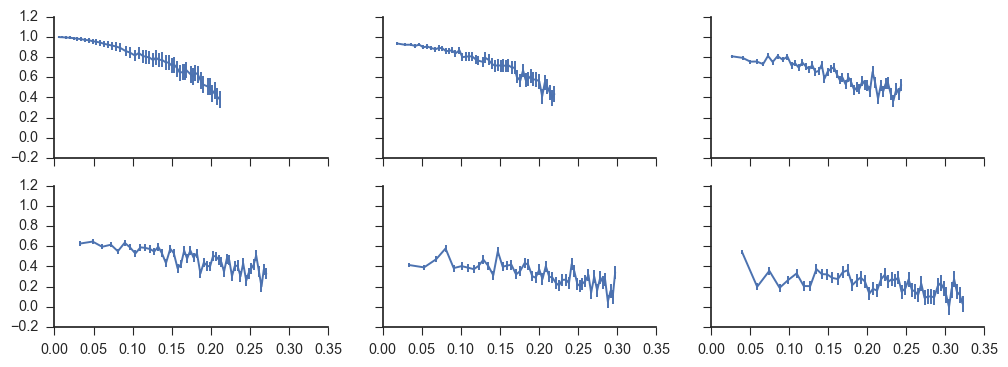

In [130]:
fig,axes = plt.subplots(2,3,figsize=(12,4),sharex=True,sharey=True)

for ax,s,d in zip(axes.ravel(),scores,dists):
    
    ax.errorbar(d[0],s[:,0],yerr=d[1])
sns.despine()

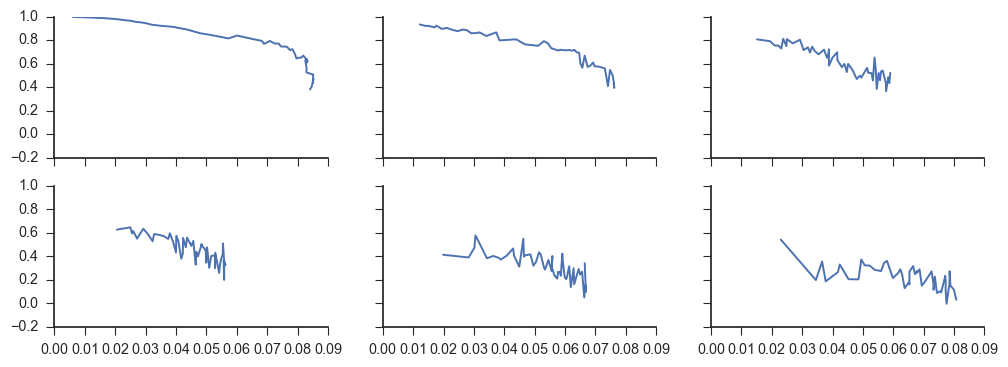

In [131]:
fig,axes = plt.subplots(2,3,figsize=(12,4),sharex=True,sharey=True)

for ax,s,d in zip(axes.ravel(),scores,dists):
    
    ax.plot(d[1],s[:,0])
sns.despine()